### Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import warnings
warnings.filterwarnings('ignore')

In [2]:
from glob import glob

In [12]:
import pathlib

# Use current directory as root path
root_path = pathlib.Path('.')

# Define the SkincancerISIC directory path
data_dir = root_path / "SkincancerISIC"

# Define training and testing directory paths inside the SkincancerISIC folder
data_dir_train = data_dir / "Train"
data_dir_test = data_dir / "Test"

# Get the count of images in the training directory
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(f"Number of training images: {image_count_train}")

# Get the count of images in the testing directory
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(f"Number of testing images: {image_count_test}")


Number of training images: 2239
Number of testing images: 118


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

WindowsPath('/SkincancerISIC/Train')

0
0


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [13]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [14]:
## Write the train dataset here
## Using seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Resize the images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split=0.2,
    subset='training',
    image_size=(img_height,img_width),
    batch_size=batch_size
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [15]:
## Validate the dataset
## Use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Resize the images to the size img_height*img_width, while writting the dataset

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split=0.2,
    subset='validation',
    image_size=(img_height,img_width),
    batch_size=batch_size
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [16]:
# List out all the classes of skin cancer and store them in a list. 

class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Visualize one instance of all the nine classes present in the dataset and see the images loaded properly.

(32, 180, 180, 3)
(32,)


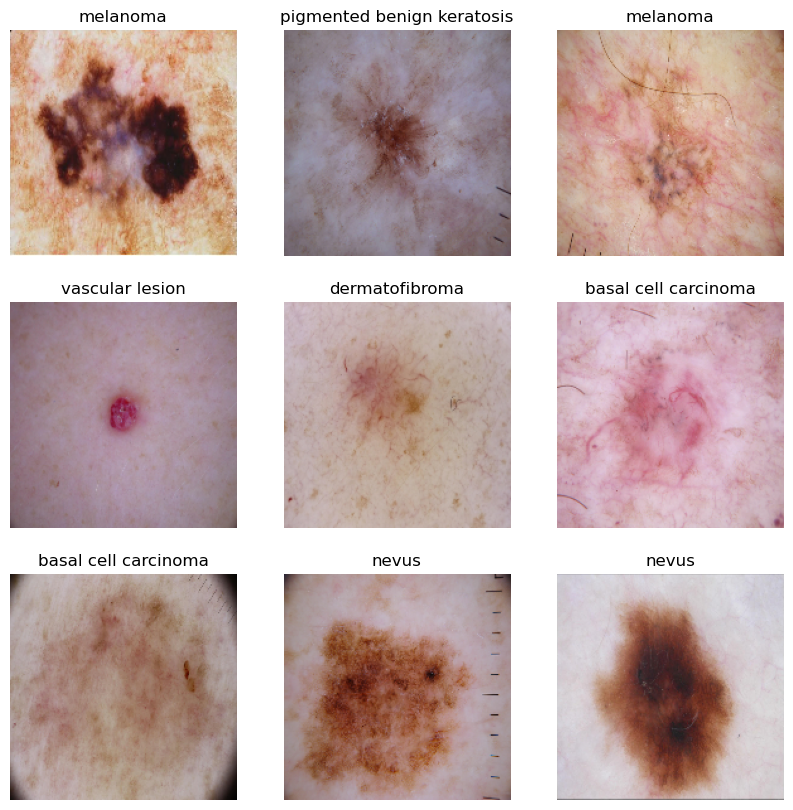

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in val_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

for image_batch, labels_batch in val_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

Using cache for loading the data from disk during first epoch and then keep the images in the in-memory. This helps to improve the performance of the model processing.

In [18]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model - 1
#### Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [20]:
from tensorflow.keras import layers, Sequential

num_classes = 9

model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),  # Rescale pixel values to the range [0, 1]
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(num_classes)  # Output layer with num_classes nodes
])


#### Choosing Optimizer and Loss Function

Adam optimization is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.

Sparse Cross Entropy Computes the crossentropy loss between the labels and predictions.

Lets use this crossentropy loss function when there are two or more label classes. We can use the categoricalCrossentropy loss function to provide labels using one-hot representation.

In [21]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [22]:
# View the summary of all layers
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,997,481 (15.25 MB)

 Trainable params: 3,997,481 (15.25 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model -1

In [23]:
epochs = 20

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  verbose=True
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 26s 286ms/step - accuracy: 0.1835 - loss: 2.1051 - val_accuracy: 0.2931 - val_loss: 1.8906
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 15s 267ms/step - accuracy: 0.3583 - loss: 1.7908 - val_accuracy: 0.4407 - val_loss: 1.5772
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 15s 275ms/step - accuracy: 0.4437 - loss: 1.5459 - val_accuracy: 0.4855 - val_loss: 1.4676
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 14s 257ms/step - accuracy: 0.5185 - loss: 1.4261 - val_accuracy: 0.5459 - val_loss: 1.3118
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 14s 255ms/step - accuracy: 0.5479 - loss: 1.2779 - val_accuracy: 0.5235 - val_loss: 1.3917
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 15s 259ms/step - accuracy: 0.5879 - loss: 1.1765 - val_accuracy: 0.5280 - val_loss: 1.3660
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 15s 259ms/step - accuracy: 0.6052 - loss: 1.1254 - val_accuracy: 0.5190 - val_loss: 1.4180
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 15s 262ms/step - accuracy: 0.6362 - loss: 0.9844 - val_accu

### Visualizing training results

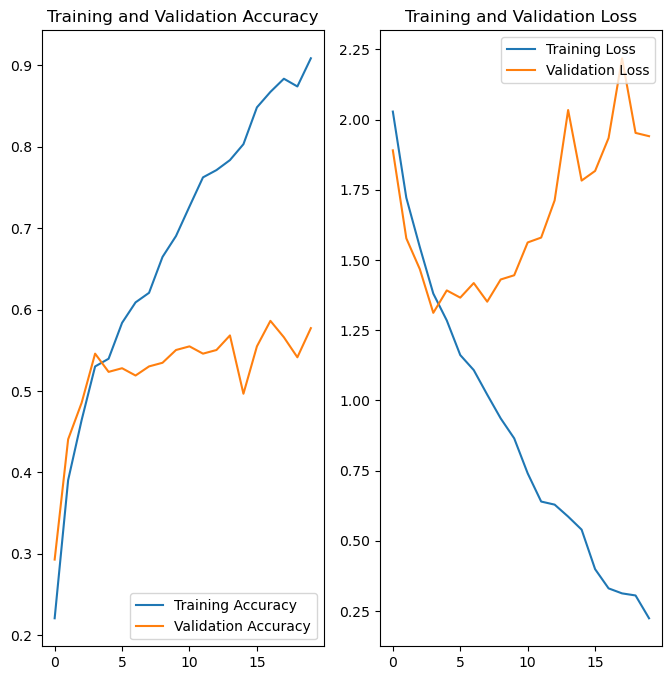

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

###Observation on the model 1;

   #### Training Accuracy:91% and Validation accuracy:57%

  #### In the above plots, the taining accuracy is increasing linearly over time, however validation accuracy is stay around 57%. There is a significant difference between the trainning accuracy and Validation accuracy.
  #### It is a sign of overfitting.
  #### Let us use Dropout and Augmentation layer to handle this overfitting and create a next module.

### Model 2 - Adding Dropout and augmentation layer with the model 1

### Data Augmentation

In [26]:
from tensorflow.keras import layers
from tensorflow.keras import Sequential

data_augmentation = Sequential(
  [
    layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)


#### Verify the Augmentation strategy by visualizing one instance of training image 

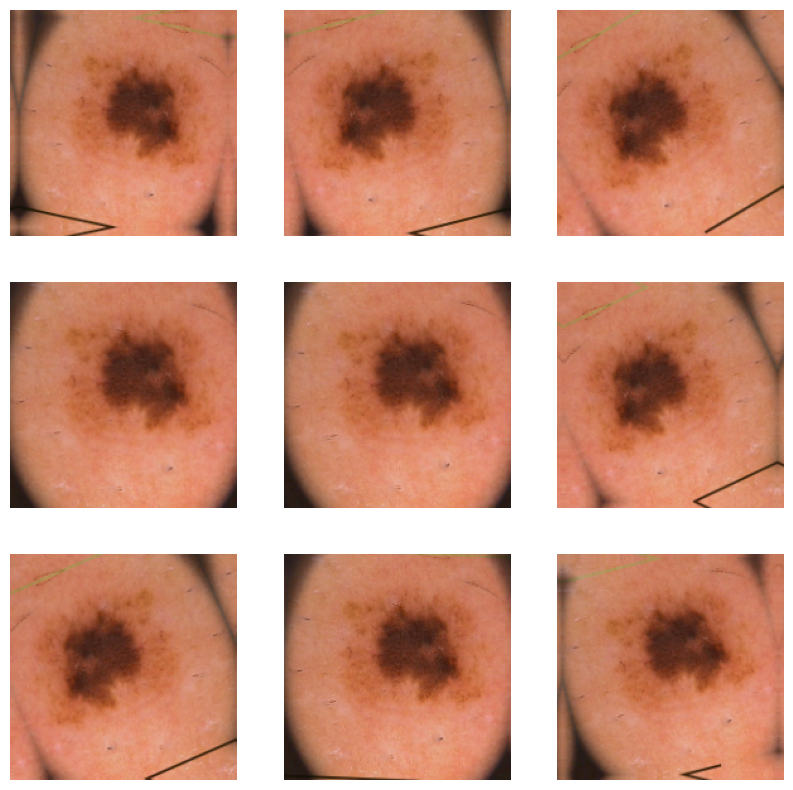

In [27]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

#### Dropout is another technique to reduce the overfitting. Dropout the 30% of output units randomly from the applied layer.

In [29]:
# Adding Model, Dropout Layers, Data Augmenting to fix the Overfitting

num_classes = 9

model = Sequential([
    data_augmentation,  # Data augmentation layers
    layers.Rescaling(1./255),  # Rescale pixel values to the range [0, 1]
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.3),  # Dropout layer to reduce overfitting
    layers.Flatten(),  # Flatten the output for the Dense layers
    layers.Dense(128, activation='relu'),  # Fully connected layer
    layers.Dense(64, activation='relu'),  # Fully connected layer
    layers.Dense(num_classes)  # Output layer for classification
])

### Compile model -2

In [30]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Train the model -2

In [31]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  verbose=True
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 23s 315ms/step - accuracy: 0.1699 - loss: 2.1085 - val_accuracy: 0.2796 - val_loss: 1.9100
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 17s 304ms/step - accuracy: 0.3566 - loss: 1.7710 - val_accuracy: 0.4273 - val_loss: 1.5867
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 17s 299ms/step - accuracy: 0.4757 - loss: 1.5334 - val_accuracy: 0.4720 - val_loss: 1.4609
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 17s 312ms/step - accuracy: 0.4784 - loss: 1.4401 - val_accuracy: 0.4743 - val_loss: 1.5384
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 17s 301ms/step - accuracy: 0.4853 - loss: 1.4352 - val_accuracy: 0.4720 - val_loss: 1.4541
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 17s 311ms/step - accuracy: 0.4953 - loss: 1.3642 - val_accuracy: 0.5369 - val_loss: 1.3484
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 17s 297ms/step - accuracy: 0.5533 - loss: 1.3009 - val_accuracy: 0.5078 - val_loss: 1.3576
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 17s 299ms/step - accuracy: 0.5159 - loss: 1.2998 - val_accu

#### Visualize the model -2 training results

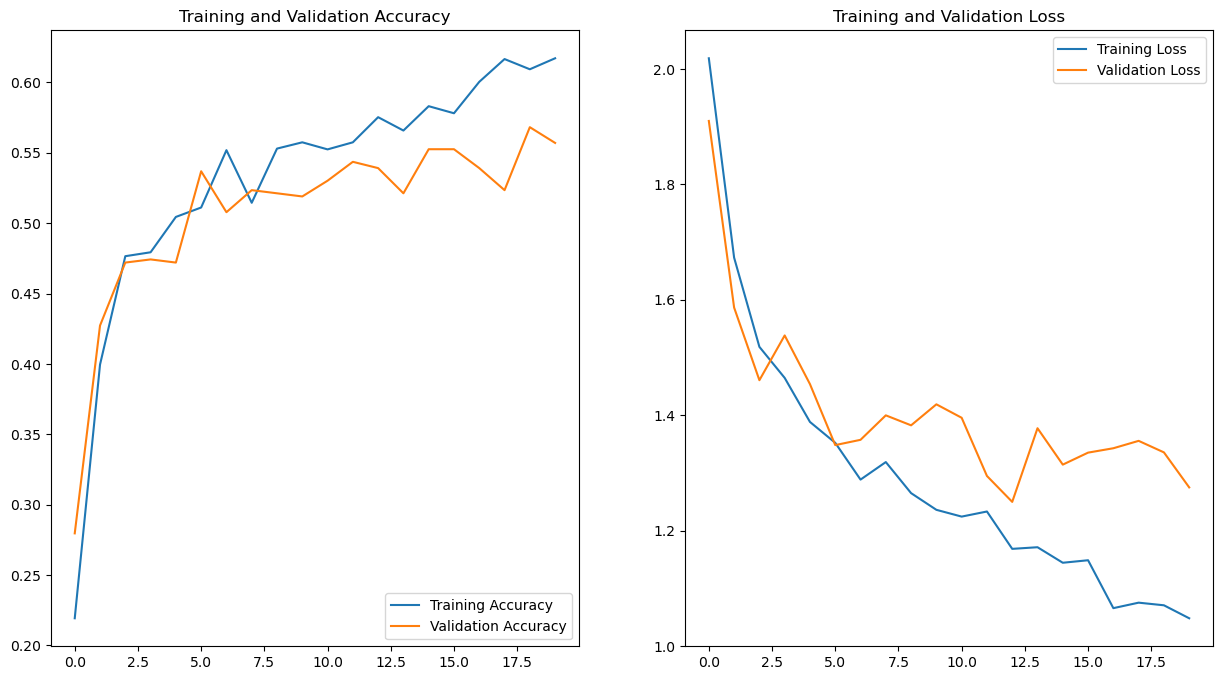

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Outfitting is resolved. However, now the accuracy is 59% for training and 54% for validation. So it is underfitting now.Lets take a look at the dataset distribution and see if there is any possibilities to improve the model 

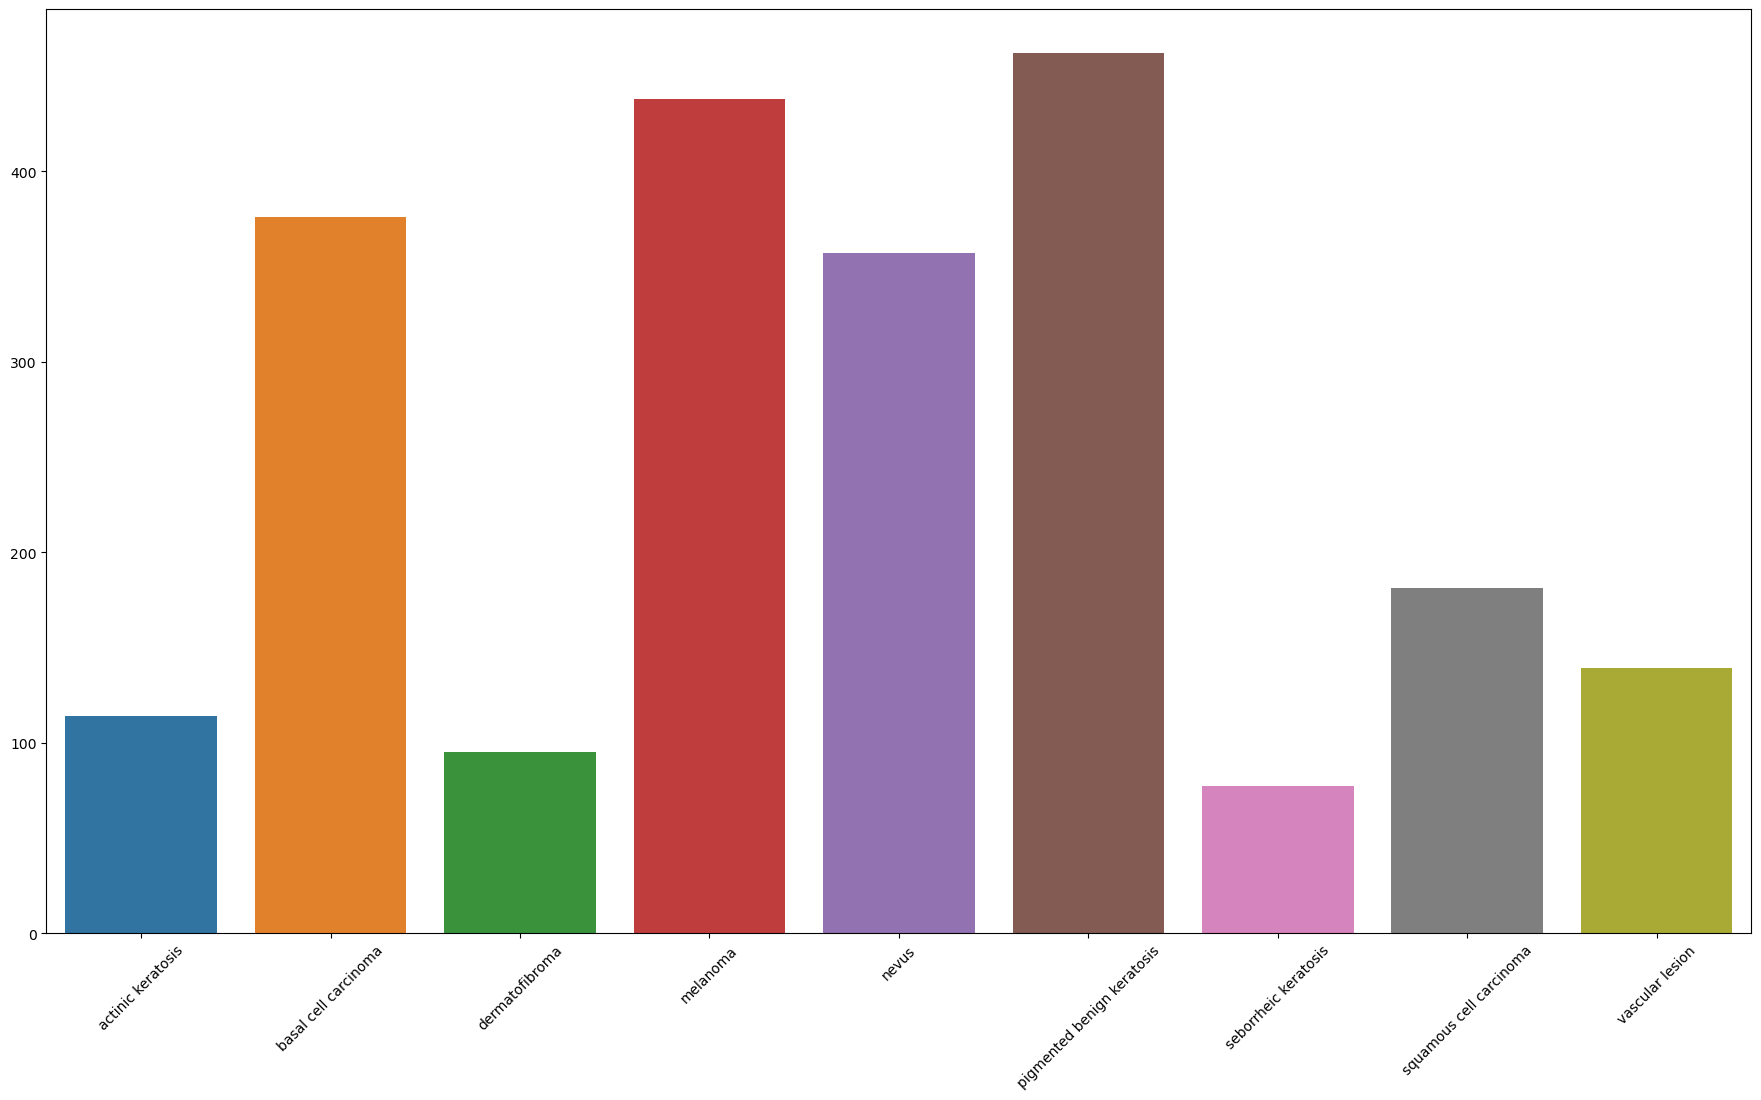

In [36]:
import seaborn as sns
# Dictionary to store class names and their corresponding image counts
class_dict_orig = {}

# Iterate through class names and count images in each class folder
for i in class_names:
    class_path = pathlib.Path(data_dir) / "Train" / i  # Proper path construction using Path
    class_count = len(list(class_path.glob('*.jpg')))   # Count .jpg files in the folder
    class_dict_orig[i] = class_count

# Plotting using seaborn
fig, ax = plt.subplots(figsize=(22,12))
sns.barplot(x=list(class_dict_orig.keys()), y=list(class_dict_orig.values()), ax=ax)
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility if needed
plt.show()

In [37]:
pd.DataFrame(list(class_dict_orig.items()),columns = ["Class Names","Number of Images"]).sort_values(by=["Number of Images"])

,Class Names,Number of Images
6,seborrheic keratosis,77
2,dermatofibroma,95
0,actinic keratosis,114
8,vascular lesion,139
7,squamous cell carcinoma,181
4,nevus,357
1,basal cell carcinoma,376
3,melanoma,438
5,pigmented benign keratosis,462


### Class Imbalance

The number of image is varying a lot. The lowest data is having 77 images and highest has 462 images.

So, lets try to use the agmentor to create mirror images to the train data set. This will help to improve the number of images in all the classes and the imbalance will get reduce among all the classes.

CNN is cabable of classify the objects even the images are in different orientation. So we cna add small changes in the agmentor like flips or rotation of the images and create a new set of mirror images.

And then use the updated data set to train the model along with the dropout, augmentation layers.

### Rectify the Class Imbalance

#### Augmentor - Data Augmentation Package

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [38]:
# Install a pip package in the current Jupyter kernel
import shutil, sys 
!{sys.executable} -m pip install Augmentor

  Obtaining dependency information for Augmentor from https://files.pythonhosted.org/packages/f3/86/5a91176650eb229ea2cd95551c34c36fba6cd95da3bdc4a5c73fbb1536ca/Augmentor-0.2.12-py2.py3-none-any.whl.metadata


In [42]:
import pathlib
import shutil
import os
import Augmentor

# Use the / operator to construct paths properly
data_dir_train = pathlib.Path(root_path) / "Train_class_balanced"

# Convert data_dir_train to string for functions that require string paths
if data_dir_train.exists():
    shutil.rmtree(data_dir_train)
    shutil.copytree(data_dir / "Train", data_dir_train)
else:
    shutil.copytree(data_dir / "Train", data_dir_train)

# Augmentor pipeline for each class
for i in class_names:
    print(f"Processing class: {i}")
    
    # Construct the path to the class directory
    class_path = data_dir_train / i
    class_path_str = str(class_path)  # Convert to string for Augmentor
    
    # Initialize Augmentor Pipeline with the class path
    p = Augmentor.Pipeline(class_path_str)
    
    # Apply augmentations
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    
    # Generate additional samples
    p.sample(500)  # Add 500 samples per class to balance the dataset

Processing class: actinic keratosis
Initialised with 114 image(s) found.
Output directory set to Train_class_balanced\actinic keratosis\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x17BC2F66450>: 100%|██████████| 500/500 [00:05<00:00, 92.81 Samples/s] 


Processing class: basal cell carcinoma
Initialised with 376 image(s) found.
Output directory set to Train_class_balanced\basal cell carcinoma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x17B749AA790>: 100%|██████████| 500/500 [00:05<00:00, 92.41 Samples/s] 


Processing class: dermatofibroma
Initialised with 95 image(s) found.
Output directory set to Train_class_balanced\dermatofibroma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x17BC2E37FD0>: 100%|██████████| 500/500 [00:05<00:00, 89.23 Samples/s]                   


Processing class: melanoma
Initialised with 438 image(s) found.
Output directory set to Train_class_balanced\melanoma\output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x17BC2D9F8D0>: 100%|██████████| 500/500 [00:28<00:00, 17.36 Samples/s]                  


Processing class: nevus
Initialised with 357 image(s) found.
Output directory set to Train_class_balanced\nevus\output.

Processing <PIL.Image.Image image mode=RGB size=2048x1536 at 0x17BC2FBA510>: 100%|██████████| 500/500 [00:26<00:00, 19.15 Samples/s]                  


Processing class: pigmented benign keratosis
Initialised with 462 image(s) found.
Output directory set to Train_class_balanced\pigmented benign keratosis\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x17BC2CF2F90>: 100%|██████████| 500/500 [00:05<00:00, 97.85 Samples/s] 


Processing class: seborrheic keratosis
Initialised with 77 image(s) found.
Output directory set to Train_class_balanced\seborrheic keratosis\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x17BC2F41350>: 100%|██████████| 500/500 [00:11<00:00, 41.90 Samples/s]


Processing class: squamous cell carcinoma
Initialised with 181 image(s) found.
Output directory set to Train_class_balanced\squamous cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x17B748B3B90>: 100%|██████████| 500/500 [00:05<00:00, 94.70 Samples/s]                   


Processing class: vascular lesion
Initialised with 139 image(s) found.
Output directory set to Train_class_balanced\vascular lesion\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x17BC2D47590>: 100%|██████████| 500/500 [00:05<00:00, 95.79 Samples/s]                   


### Lets see the distribution of augmented data after adding new images to the original training data.

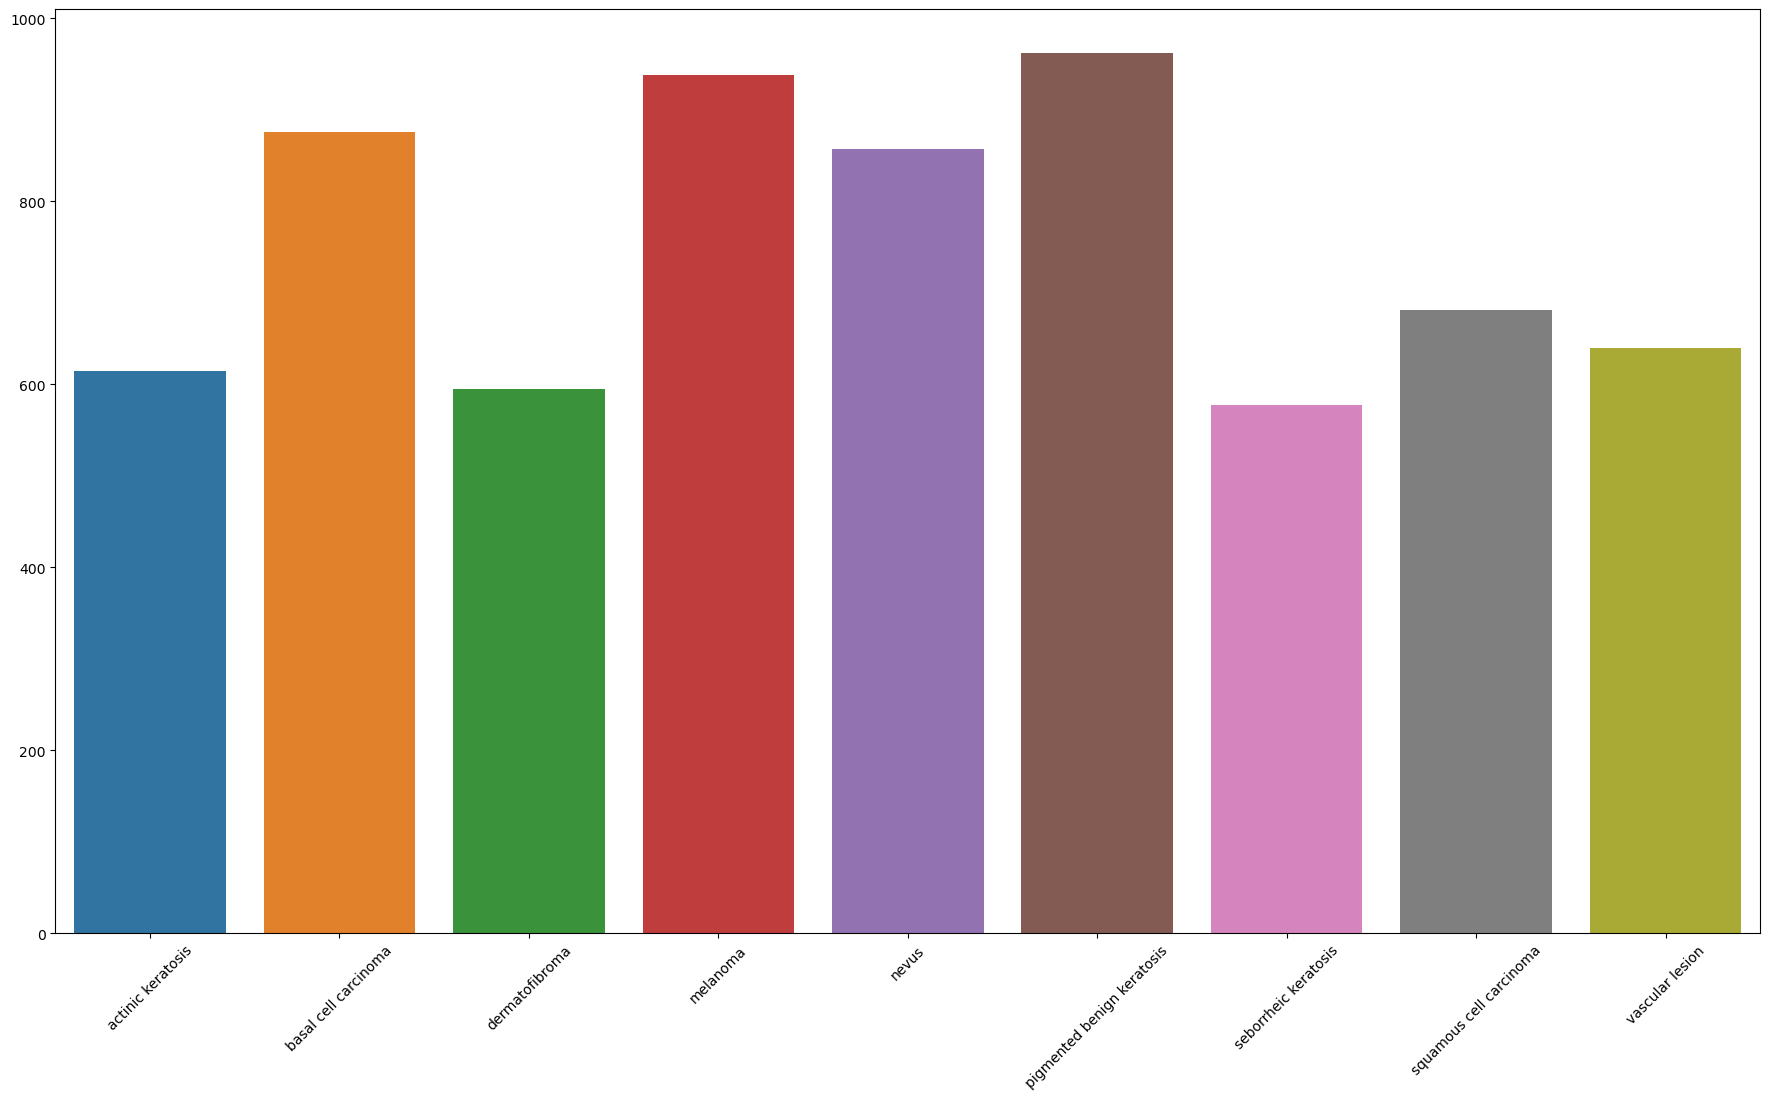

In [44]:
import pathlib
import seaborn as sns
import matplotlib.pyplot as plt

# Dictionary to store class names and their corresponding image counts
class_dict_new = {}

# Iterate through class names and count images in each class folder
for i in class_names:
    # Use / operator to join paths correctly
    class_path = pathlib.Path(data_dir_train) / i
    class_count = len(list(class_path.glob('*.jpg')))
    
    # Output path inside each class directory
    class_output_path = class_path / "output"
    class_output_count = len(list(class_output_path.glob('*.jpg')))
    
    # Store the total count (original + augmented) in the dictionary
    class_dict_new[i] = class_count + class_output_count

# Plotting using seaborn
fig, ax = plt.subplots(figsize=(22, 12))
sns.barplot(x=list(class_dict_new.keys()), y=list(class_dict_new.values()), ax=ax)
plt.xticks(rotation=45)  # Rotate x-axis labels if needed
plt.show()

In [45]:
pd.DataFrame(list(class_dict_new.items()),columns = ["Class Names","Number of Images"]).sort_values(by=["Number of Images"])

,Class Names,Number of Images
6,seborrheic keratosis,577
2,dermatofibroma,595
0,actinic keratosis,614
8,vascular lesion,639
7,squamous cell carcinoma,681
4,nevus,857
1,basal cell carcinoma,876
3,melanoma,938
5,pigmented benign keratosis,962


#### Class Imbalance is Rectified - All Classes have a minimum of 500 Images

### Model 3 : Model -1 + Dropout Layer + Data Augmentation (to counter overfitting) + Class Imbalance (to counter class imbalance) <br>

- Creating New Augmented Train Loader
- Creating New Augmented Validation Loader
- Train for 50 Epochs as data increased

In [46]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [47]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [49]:
# Vanilla Model + Dropout Layers + Data Augmentation + Class balanced Dataset

# Define the number of classes
num_classes = 9

# Build the model
model = Sequential([
    data_augmentation,  # Data augmentation layers
    layers.Rescaling(1./255),  # Rescale pixel values to [0, 1]
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),  # Dropout layer to prevent overfitting
    layers.Flatten(),  # Flatten the data for the Dense layers
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(num_classes)  # Output layer with 'num_classes' outputs
])

# Compile the model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# Train the model
epochs = 50
history = model.fit(
    train_ds,  # Training dataset
    validation_data=val_ds,  # Validation dataset
    epochs=epochs,
    verbose=True
)

Epoch 1/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 70s 384ms/step - accuracy: 0.2303 - loss: 2.0331 - val_accuracy: 0.3452 - val_loss: 1.7056
Epoch 2/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 49s 286ms/step - accuracy: 0.3904 - loss: 1.6173 - val_accuracy: 0.4573 - val_loss: 1.4098
Epoch 3/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 56s 331ms/step - accuracy: 0.4486 - loss: 1.4519 - val_accuracy: 0.4016 - val_loss: 1.5903
Epoch 4/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 67s 395ms/step - accuracy: 0.4735 - loss: 1.3888 - val_accuracy: 0.5056 - val_loss: 1.2868
Epoch 5/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 68s 400ms/step - accuracy: 0.5018 - loss: 1.2971 - val_accuracy: 0.5397 - val_loss: 1.2424
Epoch 6/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 63s 369ms/step - accuracy: 0.5243 - loss: 1.2163 - val_accuracy: 0.5605 - val_loss: 1.1881
Epoch 7/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 62s 366ms/step - accuracy: 0.5351 - loss: 1.2219 - val_accuracy: 0.5442 - val_loss: 1.2443
Epoch 8/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 61s 361ms/step - accuracy: 0.5610 - loss: 1

169/169 ━━━━━━━━━━━━━━━━━━━━ 75s 443ms/step - accuracy: 0.8632 - loss: 0.3600 - val_accuracy: 0.8352 - val_loss: 0.5673


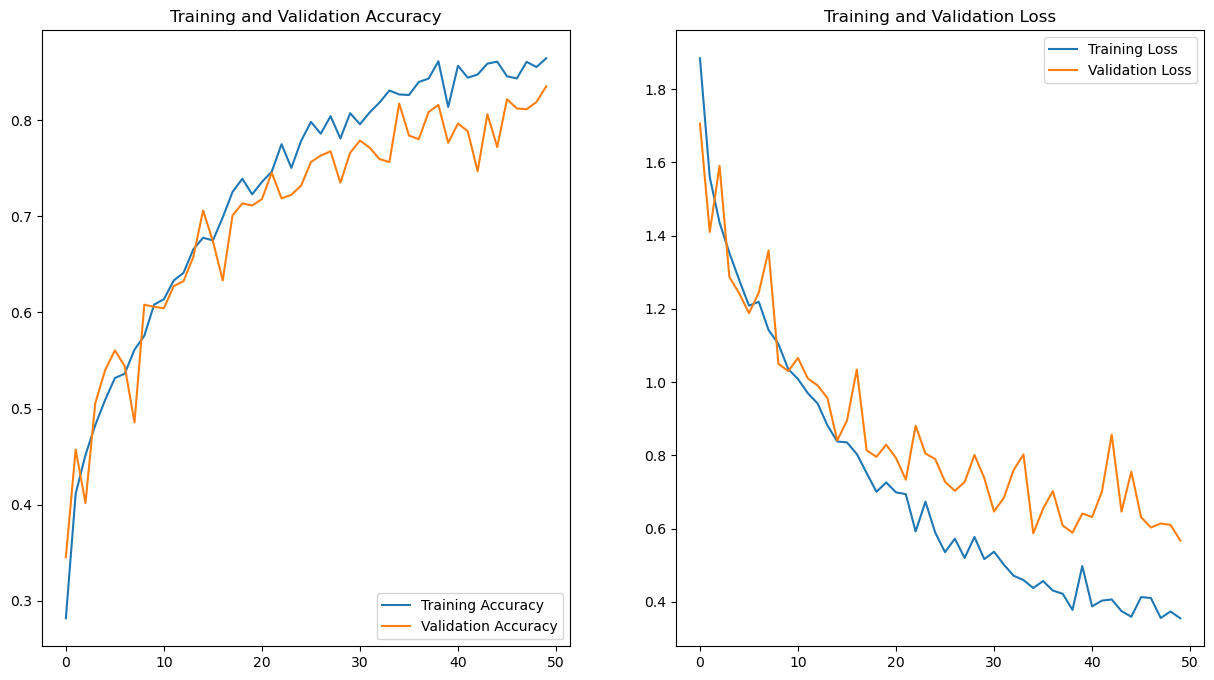

In [50]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']\

val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Underfitting is Resolved

### Model 3 : Accuracy is 86% on Training and 83% on Validation after running 50 epochs which is decent enough and more generalizable Model

## Summary

* Model -1: Basic Model
  * Model Training is not having good accuracy - Training accuracy 81% and Validation Accuracy 53%  
  * Model was **Overfitting**

* Model -2: Model 1 + Dropout Layers + Data Augmentation
  * Dropout Layers Added
  * Data Augmentation layer was added
  * Accuracy of the model is reduced compare to model -1 - Training Accuracy 56% and Validation Accuracy 51%
  * Model was **Underfitting** due to the class imbalance

* Model -3: Model 2 + Class balanced Dataset
  * To fix the class imbalance issue, Dataset Added using Augmentor (500 images added per class)
  * Same Model 2 was used.
  * The accuracy of the model is improved. So, handling the class imbalance give better result and this model is reliable model.